**Predicting Next Day Rain using Random Forest Classifier**

Binary Classification Problem

Author: Venkatesan Krishnamurthy

**Loading the essential libraries**

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, f1_score, classification_report, auc, precision_recall_curve
import os

In [135]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the Data into Pandas Dataframe**

In [136]:
df = pd.read_csv("/content/drive/MyDrive/Random_Forests/weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [137]:
# Check the number of NaNs in each column
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

**Preprocessing the Data**

In [138]:
df = df.drop(columns=["Date","Evaporation","Sunshine"]) # Dropping columns from Dataframe

In [139]:
# Label Encoding Location Names
def replace_name(location_column):
  le = LabelEncoder()
  return le.fit_transform(location_column), le.classes_
  
df["Location"], location_list = replace_name(df["Location"])

In [140]:
# Setting 0s and 1s to RainToday and RainTomorrow columns (There are many ways to do that)
df["RainToday"] = df["RainToday"].replace("No", 0)
df["RainToday"] = df["RainToday"].replace("Yes", 1)
df.loc[df["RainTomorrow"] == "No", "RainTomorrow"] = 0
df.loc[df["RainTomorrow"] == "Yes", "RainTomorrow"] = 1

# The above can be done by a map as well 
# RainToday_mapping = {'No':0, 'Yes':1}
# df['RainToday'].map(RainToday_mapping)

# Converting them to Float so that they can be interpolated
df['RainToday'] = df['RainToday'].astype("float64")
df['RainTomorrow'] = df['RainTomorrow'].astype("float64")

In [141]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,2,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,2,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,2,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


In [142]:
#df = df.drop(columns=["Date","Evaporation","Sunshine","WindGustDir","WindDir9am","WindDir3pm","Cloud3pm","Cloud9am"])

In [143]:
# Filling the missing values of each column by the mode of a respective column ( Alphabetical Columns)
fillna_list = ["WindGustDir","WindDir9am","WindDir3pm","Cloud3pm","Cloud9am"]

for i in fillna_list:
  df[i].fillna(df[i].mode()[0], inplace=True)

# Setting the Cloud Types as String (Object)
cloud_list = ["Cloud3pm","Cloud9am"] 
for i in cloud_list:
  df[i] = df[i].astype(str)

In [144]:
# Select all the columns from the dataframe of the given datatypes
numerical_df = df.select_dtypes(include=["int64", "float64"])

for i in numerical_df.columns:
  df[i] = df[i].interpolate(method="linear", axis=0)

In [145]:
df.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [146]:
# Converts Strings into OneHot Encodings. Here the String columns are WindGustDir,	WindDir9am,	WindDir3pm,	Cloud9am,	Cloud3pm
# They can be obtained by df.select_dtypes(include=["object"]).columns
df = pd.get_dummies(df)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,...,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,Cloud9am_0.0,Cloud9am_1.0,Cloud9am_2.0,Cloud9am_3.0,Cloud9am_4.0,Cloud9am_5.0,Cloud9am_6.0,Cloud9am_7.0,Cloud9am_8.0,Cloud9am_9.0,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_5.0,Cloud3pm_6.0,Cloud3pm_7.0,Cloud3pm_8.0,Cloud3pm_9.0
0,2,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,2,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,2,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [147]:
# Getting Y array and setting it to int32 because classification requires in that format
Y = df["RainTomorrow"].copy()
Y = Y.astype("int32")

# Removing RainTomorrow from X
X = df.drop(columns=["RainTomorrow"])

**Train Test Split**

In [148]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, shuffle=True, random_state=10)

**Feature Importances** (Removing Highly dependent features)

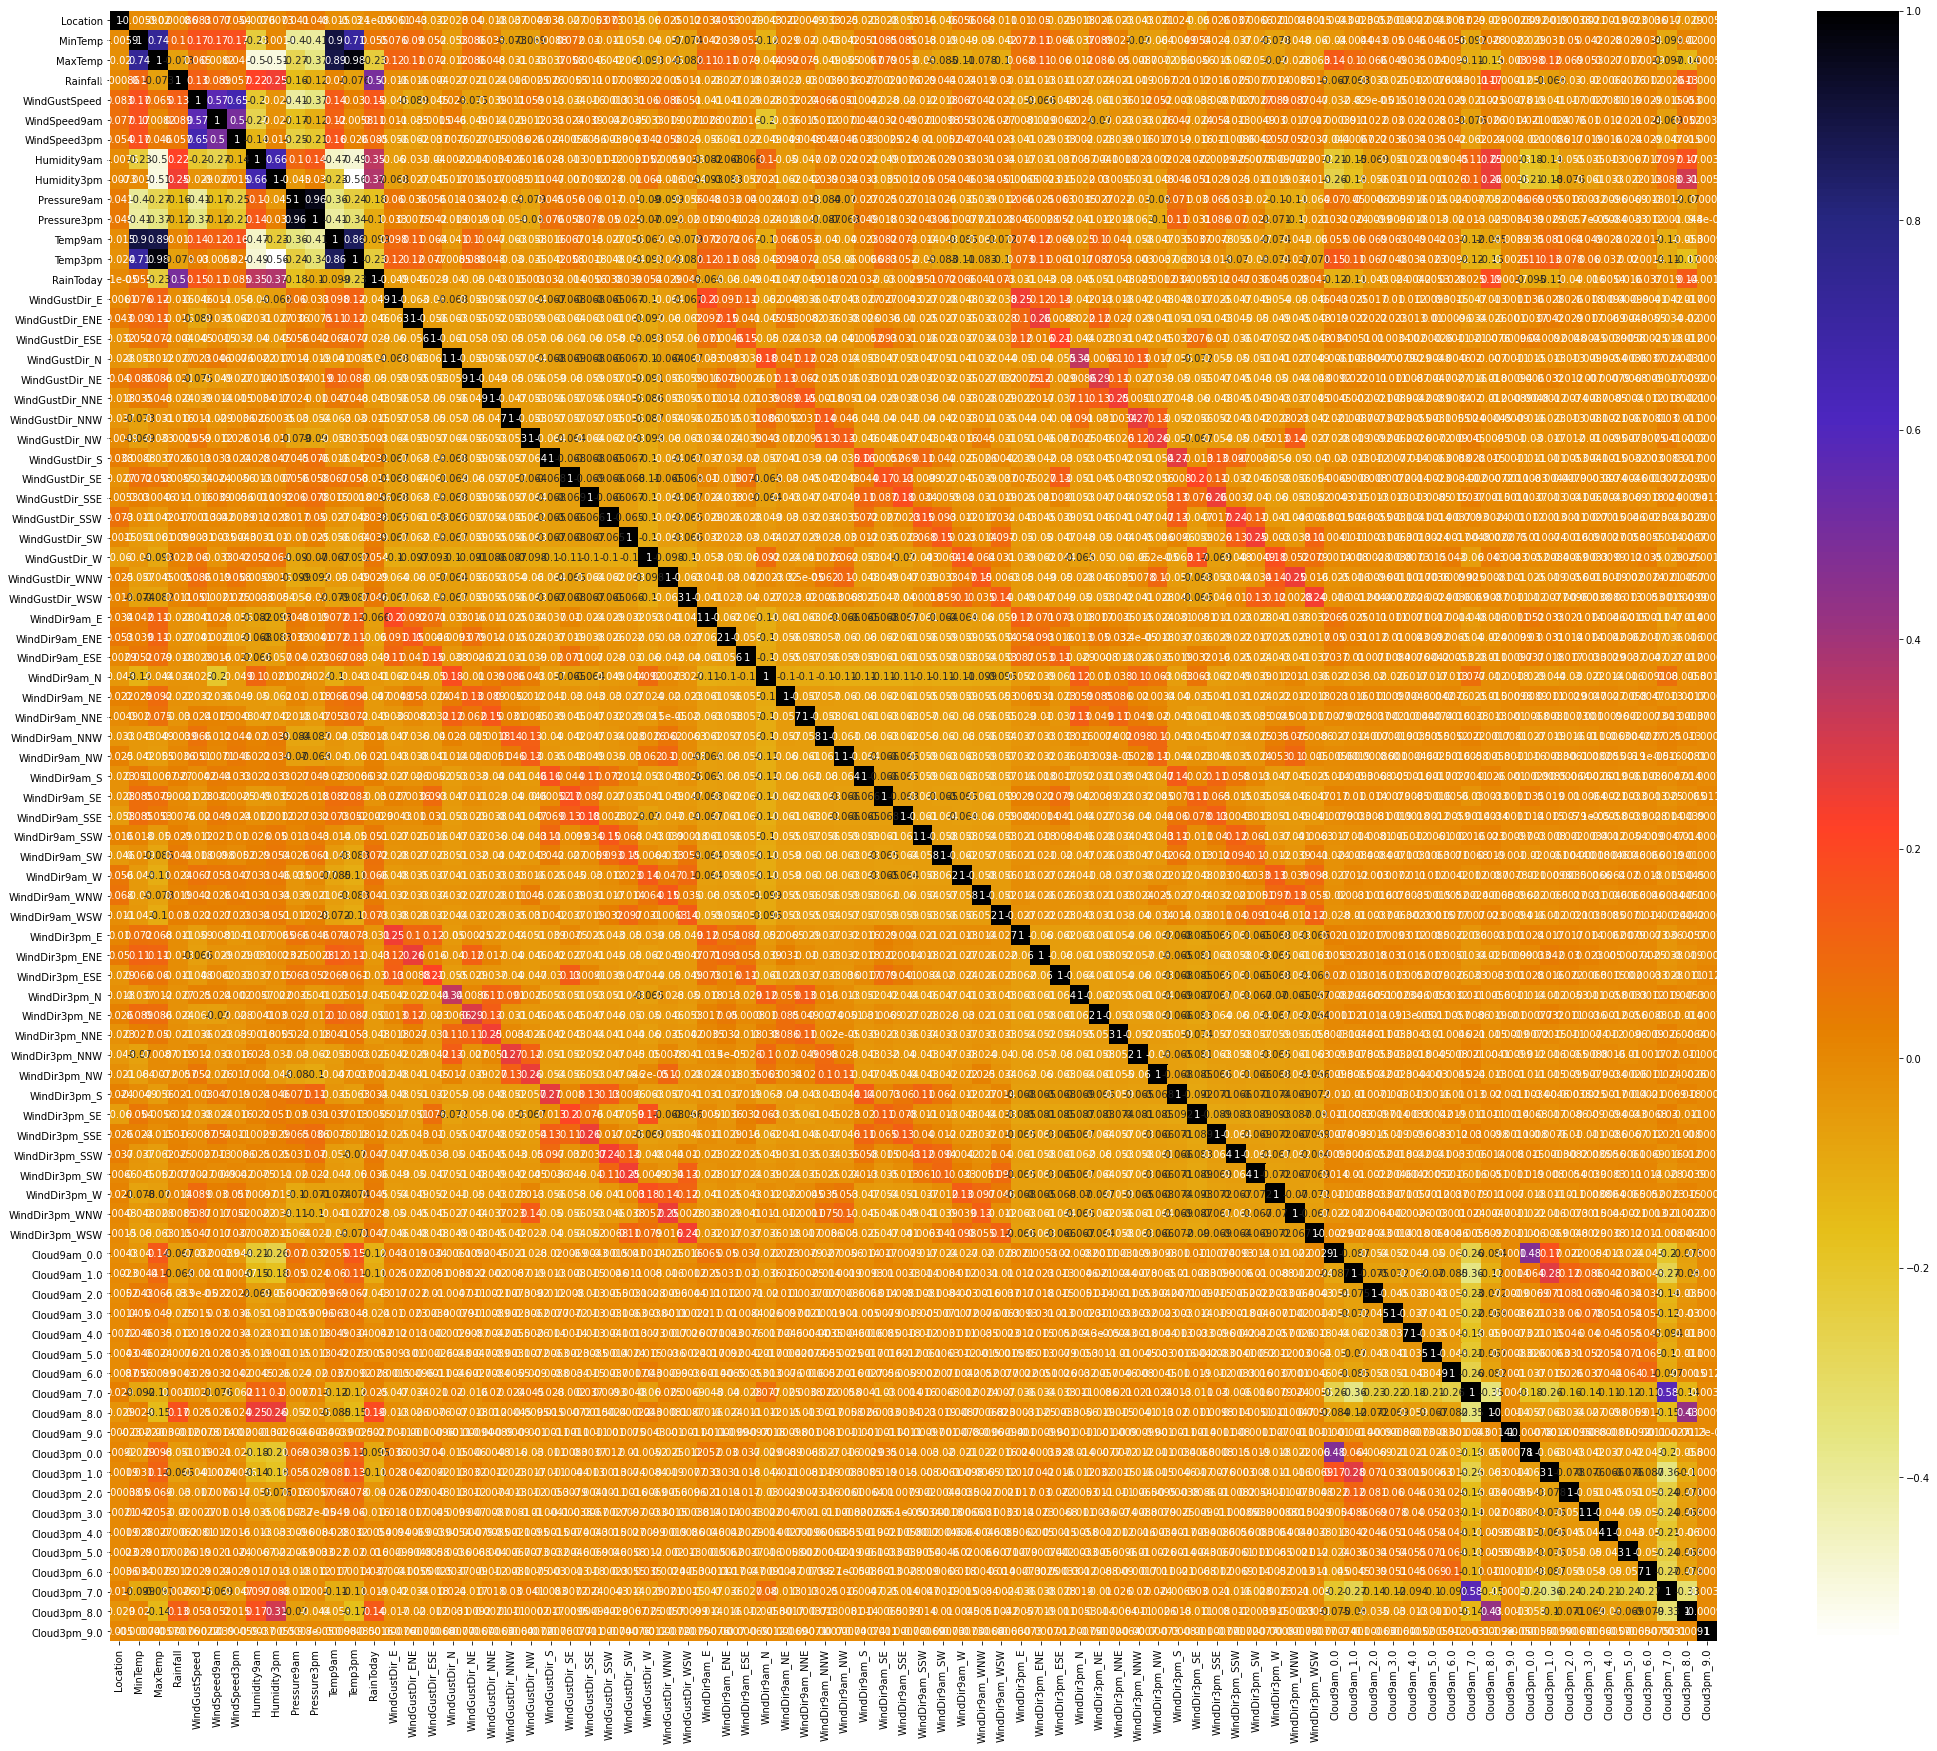

In [149]:
import seaborn as sns
# Using Pearson Correlation (-1 Highly uncorrelated, 0 No relation, 1 Highly correlated)
plt.figure(figsize=(36,30))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [150]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [151]:
# These features are highly correlated with other features. This means that they are duplicate features which mean the same thing as some other features in the data.
# So we remove them to make the model not dependent upon two features which mean the same.
corr_features = correlation(X_train, 0.85)
corr_features

{'Pressure3pm', 'Temp3pm', 'Temp9am'}

In [152]:
# Dropping those columns
X_train = X_train.drop(corr_features, axis=1)
X_test = X_test.drop(corr_features, axis=1)

**Feature Importances** (Choosing the n-most important features)

In [153]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information

mutual_info = mutual_info_classif(X_train, Y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns # Setting the indices as X_train column names
mutual_info.sort_values(ascending=False) # Showing the best features in descending order

Humidity3pm       0.112303
Rainfall          0.055803
RainToday         0.051304
Humidity9am       0.038332
Pressure9am       0.033400
                    ...   
WindGustDir_N     0.000000
WindDir9am_NNW    0.000000
WindDir9am_ENE    0.000000
WindDir9am_NNE    0.000000
WindDir9am_E      0.000000
Length: 79, dtype: float64

In [154]:
from sklearn.feature_selection import SelectKBest
# Choosing the n-best features

best_features = SelectKBest(mutual_info_classif, k=25)
best_features.fit(X_train, Y_train)

best_columns = X_train.columns[best_features.get_support()] # get_support gives the boolean of the best n-columns

In [155]:
# Only keeping the best features in the test and train dataset
X_train = X_train[best_columns]
X_test = X_test[best_columns]

In [156]:
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,RainToday,WindGustDir_NW,WindDir9am_SE,Cloud9am_0.0,Cloud9am_1.0,Cloud9am_5.0,Cloud9am_7.0,Cloud9am_8.0,Cloud3pm_0.0,Cloud3pm_1.0,Cloud3pm_2.0,Cloud3pm_3.0,Cloud3pm_4.0,Cloud3pm_7.0,Cloud3pm_8.0
96775,0,8.5,23.1,0.0,43.0,15.0,26.0,45.0,23.0,1012.3,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
96840,0,17.9,22.1,0.0,46.0,17.0,24.0,64.0,40.0,1017.9,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
66795,19,11.1,17.5,0.4,52.0,28.0,28.0,55.0,47.0,1017.2,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
104598,28,3.6,22.1,0.0,41.0,17.0,19.0,54.0,32.0,1022.8,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
137064,3,7.3,23.6,0.0,41.0,28.0,20.0,16.0,14.0,1021.4,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


**Random Forest Classifier**

In [157]:
# Training the Data
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [158]:
# Accuracy and other metrics

Y_pred = rfc.predict(X_train)
print("Train Accuracy:", accuracy_score(Y_train, Y_pred))

Y_pred = rfc.predict(X_test)
print("Test Accuracy:", accuracy_score(Y_test, Y_pred))

print("\nPrecision score: ", precision_score(Y_test, Y_pred))
print("Recall score: ", recall_score(Y_test, Y_pred))
print("f1 score: ", f1_score(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion_Matrix: \n", cm)

Train Accuracy: 0.9996047023236628
Test Accuracy: 0.8512993262752647

Precision score:  0.7554858934169278
Recall score:  0.4861132660977502
f1 score:  0.5915785498489425

Confusion_Matrix: 
 [[21633  1014]
 [ 3312  3133]]


In [159]:
# Getting the feature importances to check if any column can be removed.
feature_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp

Humidity3pm       0.208350
Pressure9am       0.095625
WindGustSpeed     0.084589
Humidity9am       0.082761
MinTemp           0.082160
MaxTemp           0.080818
Rainfall          0.077316
Location          0.060740
WindSpeed3pm      0.057705
WindSpeed9am      0.053268
RainToday         0.032899
Cloud3pm_8.0      0.019063
Cloud9am_7.0      0.010116
Cloud3pm_7.0      0.009462
Cloud9am_8.0      0.007839
WindGustDir_NW    0.006345
Cloud3pm_1.0      0.004741
WindDir9am_SE     0.004621
Cloud9am_1.0      0.004544
Cloud9am_5.0      0.004228
Cloud3pm_3.0      0.003619
Cloud3pm_4.0      0.003344
Cloud3pm_2.0      0.003038
Cloud9am_0.0      0.001699
Cloud3pm_0.0      0.001110
dtype: float64

In [165]:
# It looks like certain features are not used much in our decision. We can remove those features to reduce the size of the dataset and speedup the training.
filtered_features = rfc.feature_importances_ > 0.007

X_train_2 = X_train[X_train.columns[filtered_features]]
X_test_2 = X_test[X_test.columns[filtered_features]]

In [166]:
print("Reduced Feature Columns for training and testing:\n", X_train.columns[filtered_features])

Reduced Feature Columns for training and testing:
 Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'RainToday', 'Cloud9am_7.0', 'Cloud9am_8.0',
       'Cloud3pm_7.0', 'Cloud3pm_8.0'],
      dtype='object')


In [167]:
# Re-training with reduced features
rfc_2 = RandomForestClassifier(n_estimators=50)
rfc_2.fit(X_train_2, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [168]:
# Accuracy and other metrics

Y_pred = rfc_2.predict(X_train_2)
print("Train Accuracy:", accuracy_score(Y_train, Y_pred))

Y_pred = rfc_2.predict(X_test_2)
print("Test Accuracy:", accuracy_score(Y_test, Y_pred))

print("\nPrecision score: ", precision_score(Y_test, Y_pred))
print("Recall score: ", recall_score(Y_test, Y_pred))
print("f1 score: ", f1_score(Y_test, Y_pred))

cm = confusion_matrix(Y_test, Y_pred)
print("\nConfusion_Matrix: \n", cm)

Train Accuracy: 0.9996132957514093
Test Accuracy: 0.8505087309225904

Precision score:  0.7509578544061303
Recall score:  0.48657874321179206
f1 score:  0.5905281988513323

Confusion_Matrix: 
 [[21607  1040]
 [ 3309  3136]]


*We can see that the test accuracy of the model has not significantly changed with the reduced features. But by removing 10 features we have improved the computation time while training.*



---



**Side Note on Imbalanced Data**

This Dataset is imbalanced. No Rain: 90461, Yes Rain: 25907

Therefore accuracy cannot be the only metric to be trusted if we want our model to focus more on True label ( Will it rain tomorrow? "Yes" ).

Hence we also have to look at other metrics like Precision, Recall and confusion matrix based on our use case.


**Precision**: Of all the samples that were labeled as "It will rain tomorrow", in how many samples it actually rained tomorrow?

**Recall**: Of all the samples that rained tomorrow how many did we correctly label?

**F1 score** - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

We can adjust the precision and recall of our model by setting a treshold to the prediction based on the **precision_recall_curve** (for imbalanced data).
For balanced data use ROC curves. 

Logistic: f1=0.592 auc=0.702


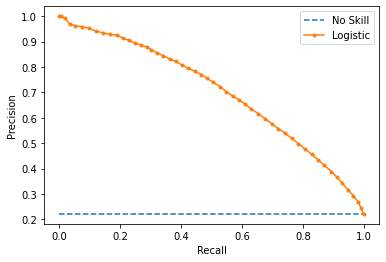

In [164]:
# predict probabilities
lr_probs = rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = rfc.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()



---



**References**

Dataset:
1.  https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Understanding RFC:
1.    https://www.datacamp.com/community/tutorials/random-forests-classifier-python
2. https://towardsdatascience.com/understanding-random-forest-58381e0602d2
3. https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
4. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Metrics, Feature Selections and Other Evaluations:
1. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
2.   https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
3. https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
4. https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
5. https://www.mygreatlearning.com/blog/random-forest-algorithm/
6. https://youtu.be/81JSbXZ26Ls
7. https://youtu.be/FndwYNcVe0U
